In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


In [3]:
from nips2018.movie import data, parameters, models
from nips2018.movie.analysis import performance
import pandas as pd
import seaborn as sns
import datajoint as dj
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torch.autograd import Variable
import torch
from itertools import product, chain
import sys
from tqdm import tqdm
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
from attorch.train import early_stopping
from nips2018.utils.measures import corr
from contextlib import contextmanager
from nips2018.movie.transforms import Subsample
from attorch.dataloaders import RepeatsBatchSampler
from nips2018.movie.analysis import performance

def train_label(row, train=True):
    if train:
        h = row.data_hash
    else:
        h = row.test_data_hash
        
    if row.preproc_id == 1:
        return 'Movie'
    elif row.preproc_id == 2:
        return 'Noise'
    else:
        return 'Movie & Noise'

@contextmanager
def silence():
    old_stdout = sys.stdout
    sys.stdout = open('/dev/null', 'w')
    try:
        yield
    finally:
        sys.stdout = old_stdout

# Load Model

In [4]:
# group_id=17
# animal_id = 17358
# session=5
# scan_idx=3

group_id=20
animal_id = 17797
session=8
scan_idx=5


key = (models.Encoder() & dict(
                core_hash='22d11147b37e3947e7d1034cc00d402c',
                ro_hash='bf00321c11e46d68d4a42653a725969d', 
#                 ro_hash='2e577c259dd5629677a353f43ab528fb', # more regularization
                data_hash='a4ecafc831670c7744ffe22320df77b7',
                train_hash='624f62a2ef01d39f6703f3491bb9242b', 
                group_id=group_id)).fetch1("KEY")

base_data = [dict(group_id=key['group_id'], animal_id=animal_id, session=session, scan_idx=scan_idx)]
scan_name = lambda i,j: '{animal_id}-{session}-{scan_idx}-{}'.format(j, **base_data[i])
rokey = lambda i,j: 'group{group_id:03d}-{animal_id}-{session}-{scan_idx}-{}'.format(j, **base_data[i])
scan_restr = \
    lambda i,j:  'animal_id={animal_id} and session={session} and scan_idx={scan_idx} and preproc_id={}'.format(
                j, **base_data[i])

In [5]:
with silence():
    model = models.Encoder().load_model(key)
    model.eval()

In [6]:
with silence():
    data, loaders = parameters.DataConfig().load_data(key, tier='test')
A = set(loaders[rokey(0,1)].sampler.indices)
B =  set(loaders[rokey(0,2)].sampler.indices)
assert len(A & B) == 0, 'indices overlap'

# Loss surface

In [7]:
group_id=17 # 20

In [8]:
def load_scores(group_id, source):
    tdh = "5253599d3dceed531841271d6eeba9c5" if source == "Movies" else "6c0290da908317e55c4baf92e379d651"
    rel = (performance.ReadoutConvexComination.Scores() & 'test_data_hash="{}"'.format(tdh) & dict(group_id=group_id))
    l_mov, l_noise, pearson, poisson = rel.fetch('lambda_movies','lambda_noise', 'pearson', 'poisson', order_by="lambda_movies ASC, lambda_noise ASC")
    l_mov = np.fromiter(map(float, l_mov), dtype=float)
    l_noise = np.fromiter(map(float, l_noise), dtype=float)
    l_mov, l_noise, pearson, poisson = map(lambda x: x.reshape((11, 11)), [l_mov, l_noise, pearson, poisson])
    return l_mov, l_noise, pearson, poisson


l_mov, l_noise, pearson_noise, poisson_noise = load_scores(group_id, "Noise")
l_mov, l_noise, pearson_nat, poisson_nat = load_scores(group_id, "Movies")



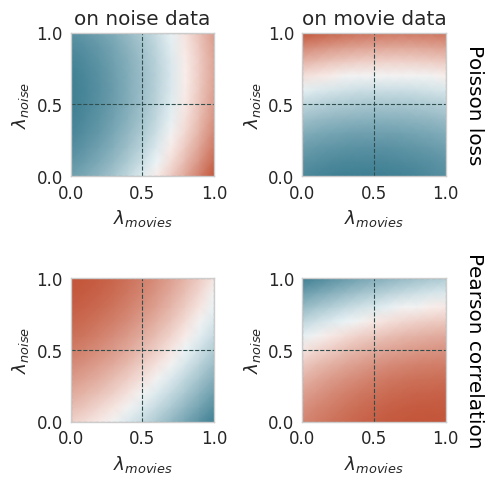

In [9]:
sns.set_context('paper', font_scale=1.5)
cmap = sns.diverging_palette(220, 20, as_cmap=True)
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(2,2, figsize=(5, 5), dpi=100)

def plotit(ax, l_mov, l_noise, M):
    h = ax.pcolormesh(l_mov, l_noise, M, cmap=cmap, shading='gouraud', zorder=-10)
    ax.set_xlabel(r'$\lambda_{movies}$')
    ax.set_ylabel(r'$\lambda_{noise}$')
    ax.grid(zorder=10, color='darkslategray', linestyle='--')
    ax.set_aspect(1)
    ax.set_xticks(np.linspace(0,1,3))
    ax.set_yticks(np.linspace(0,1,3))
    ax.set_xlim((0,1))
    ax.set_ylim((0,1))
    
plotit(ax[0, 0], l_mov, l_noise, poisson_noise)
plotit(ax[0, 1], l_mov, l_noise, poisson_nat)
plotit(ax[1, 0], l_mov, l_noise, pearson_noise)
plotit(ax[1, 1], l_mov, l_noise, pearson_nat)
ax[0,0].set_title('on noise data')
ax[0,1].set_title('on movie data')
ax[1,1].text(1.2, 0.5, 'Pearson correlation', horizontalalignment='center',verticalalignment='center', transform=ax[1,1].transAxes, rotation=-90)
ax[0,1].text(1.2, 0.5, 'Poisson loss', horizontalalignment='center',verticalalignment='center', transform=ax[0,1].transAxes, rotation=-90)
fig.tight_layout()
fig.subplots_adjust(left=.15, right=.9, bottom=.1)
fig.savefig('figures/loss_surface_group{group_id}.png'.format(group_id=group_id), dpi=200)